In [33]:
import requests
import pandas as pd
import datetime

def tick_to_price(tick, decimals0, decimals1):
    return 1.0001 ** - tick * (10 ** (decimals1 - decimals0))

def fetch_uniswap_swaps(pool_address, total_nb_swaps, limit=1000):
    endpoint = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    query = """
    query MyQuery($pool: String!, $first: Int!, $skip: Int!) {
      swaps(
        where: {pool: $pool}
        orderBy: timestamp
        orderDirection: desc
        first: $first
        skip: $skip
      ) {
        amount0
        amount1
        amountUSD
        origin
        tick
        sqrtPriceX96
        sender
        recipient
        timestamp
        recipient
        id
        sqrtPriceX96
        tick
        token1 {
          decimals
          symbol
        }
        token0 {
          decimals
          symbol
        }
        transaction {
          gasUsed
          gasPrice
          blockNumber
          timestamp
        }
      }
    }
    """

    swaps = []
    skip = 0

    while len(pd.DataFrame(swaps)) < total_nb_swaps:
        variables = {"pool": pool_address, "first": limit, "skip": skip}
        response = requests.post(endpoint, json={'query': query, 'variables': variables})
        try:
            data = response.json()['data']['swaps']
        except:
            pass
        swaps.extend(data)
        skip += limit
        
    df = pd.DataFrame(swaps)
    
    df[['amount0', 'amount1', 'amountUSD', 'timestamp']] = df[['amount0', 'amount1', 'amountUSD', 'timestamp']].astype('float')
    df[['sender', 'recipient', 'origin']] = df[['sender', 'recipient', 'origin']].astype('str')

    df['gasUsed']  = df['transaction'].apply(lambda x: x['gasUsed']).astype('int')
    df['gasPrice_wei'] = df['transaction'].apply(lambda x: x['gasPrice']).astype('int')
    df['gasPrice_eth'] = df['gasPrice_wei']*10**-18
    
    df['blockNumber'] = df['transaction'].apply(lambda x: x['blockNumber']).astype('int')
    #df['timestamp'] = df['transaction'].apply(lambda x: x['timestamp']).astype('int')
    
    df['symbol0'] = df['token0'].apply(lambda x: x['symbol']).astype('str')
    df['symbol1'] = df['token1'].apply(lambda x: x['symbol']).astype('str')

    df['decimal0'] = df['token0'].apply(lambda x: x['decimals']).astype('int')
    df['decimal1'] = df['token1'].apply(lambda x: x['decimals']).astype('int')

    df['tick']  = df['tick'].astype('int')
    df['price'] = df.apply(lambda row: tick_to_price(row['tick'], row['decimal0'], row['decimal1']), axis=1)

    df['tcost_usd'] = df['gasPrice_eth']*df['price']*df['gasUsed']
    
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')

    df = df.drop(['token1', 'token0', 'tick', 'decimal0', 'decimal1', 'id', 'sqrtPriceX96', 'transaction'], axis=1)
    
    df = df.set_index('time')
    
    path = df.iloc[0].symbol1 + '_' + df.iloc[0].symbol0 + '_pool_swap-' + str(df.index[0].date()) + '_' + str(df.index[-1].date()) + '.pkl'
    df.to_pickle(path)

    return df

In [34]:
pool_address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
df = fetch_uniswap_swaps(pool_address, total_nb_swaps=5_000)
df

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_gwei,gasPrice_eth,blockNumber,symbol0,symbol1,price,tcost_usd
time,,,,,,,,,,,,,,,
2024-02-05 22:24:59,-2286.243874,1.000000,2287.208735,0xcc731095cd449eabe6b02a313d78fd65f266cc29,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.707172e+09,281958,24128883740,2.412888e-08,19165015,USDC,WETH,2287.502499,15.562638
2024-02-05 22:24:35,2373.699454,-1.037215,2373.513835,0xb095411870213935a7fccd7591b499889eb89865,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.707172e+09,354439,44296055371,4.429606e-08,19165013,USDC,WETH,2287.502499,35.914360
2024-02-05 22:24:23,-3.857269,0.001687,3.858905,0xeeac50b46982b122553e626a6e101fc4fa086e5d,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xeeac50b46982b122553e626a6e101fc4fa086e5d,1.707172e+09,441749,22249760495,2.224976e-08,19165012,USDC,WETH,2287.502499,22.483426
2024-02-05 22:24:23,-128057.554913,56.000481,128098.188100,0x24f7ef98522dd61d529464f67bb3ffe96ea8afc2,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,1.707172e+09,350000,56686137752,5.668614e-08,19165012,USDC,WETH,2287.502499,45.384389
2024-02-05 22:24:23,-1595.326281,0.697795,1596.000665,0xfdc27a55425718097e61924c2a604b5f694e2b8b,0x1111111254eeb25477b68fb85ed929f73a960582,0x393ad9d01f799c583de1dd5dda845a0158df4081,1.707172e+09,307531,22249475113,2.224948e-08,19165012,USDC,WETH,2287.502499,15.652015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-04 20:57:35,-299.000000,0.129955,299.024125,0x5c8d805eac83460bc07006cf50b1aa66b037b84f,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.707080e+09,641134,20235133518,2.023513e-08,19157462,USDC,WETH,2301.958531,29.864303
2024-02-04 20:57:11,500.000000,-0.217102,499.793611,0x2d614d10dd4d7eb238907956b1f81d63b667b233,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.707080e+09,232423,18804591185,1.880459e-08,19157460,USDC,WETH,2301.958531,10.060985
2024-02-04 20:57:11,3776.000000,-1.639546,3774.427831,0xe7f525dd1bc6d748ae4d7f21d31e54741e05e110,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.707080e+09,214006,18804449919,1.880445e-08,19157460,USDC,WETH,2301.958531,9.263691


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_10892/866052578.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('blockNumber').mean().tcost_usd.rolling(50).mean().plot()


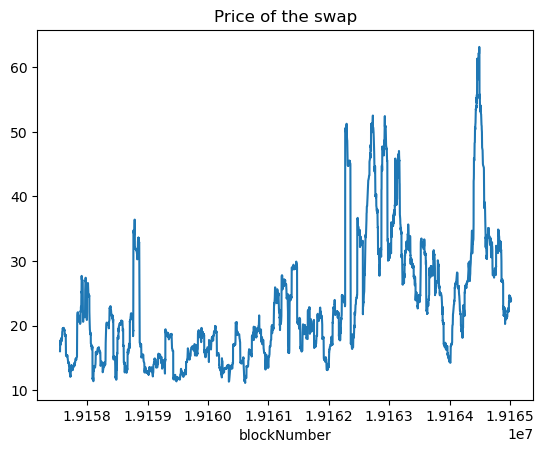

In [41]:
import matplotlib.pyplot as plt 
df.groupby('blockNumber').mean().tcost_usd.rolling(50).mean().plot()
plt.title('Price of the swap')
plt.show()

In [36]:
# those can be considered non arbitrager possibly 
# cause they need to go through the app ui to swap and there is no possibility to select whos the receiver address

print('Percent of pure guys :',round(len(df[df.sender == df.recipient])*100/len(df), 4), '%')

Percent of pure guys : 61.1176 %


In [4]:
print(df.iloc[0].origin)
print(df.iloc[0].sender)

0x8d8ace898ae37e124be2ae7635a476a288bfdc95
0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad


In [35]:
print('Percent of unique origines :',round(len(df.origin.unique())*100/len(df), 4), '%')
print('Percent of unique senders  :',round(len(df.sender.unique())*100/len(df), 4), '%')
print('Percent of unique recipient:',round(len(df.recipient.unique())*100/len(df), 4), '%')

Percent of unique origines : 0.7046 %
Percent of unique senders  : 0.0224 %
Percent of unique recipient: 0.208 %
